In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

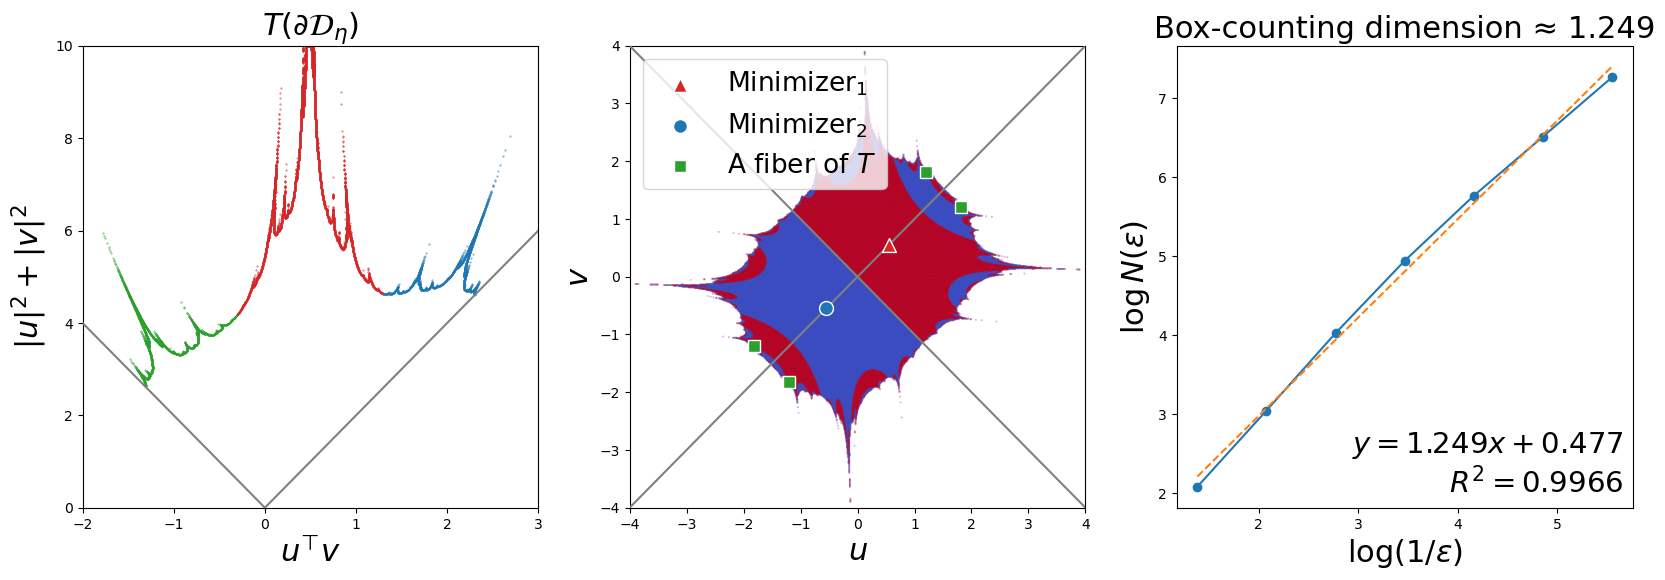

In [2]:
# Ignore warnings when computing divergent gradient descent trajectory
np.seterr(over='ignore')
np.seterr(invalid='ignore')

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

y = 0.5
h = 1.
r = 0.2
FS = 22
N_step = 200
ax = axs[0]
def F(z, w, h, r, y):
    term1 = h**2 * z**3
    term2 = h**2 * y * z**2
    term3 = ((1 - h * r)**2 - h * w + h**2 * r * w) * z
    term4 = y * h**2 * r**2 - 2 * y * h * r
    f1 = term1 + term2 + term3 + term4

    term5 = (1 - h * r)**2 + h**2 * z**2
    term6 = 4 * h * z * (1 - h * r) * (z + y)
    f2 = term5 * w - term6

    return f1, f2

z_min, z_max = -2.5, 3
w_min, w_max = 0, 10
num_points = 2000
z_vals = np.linspace(z_min, z_max, num_points)
w_vals = np.linspace(w_min, w_max, num_points)
Z, W = np.meshgrid(z_vals, w_vals)
mask = W >= 2 * np.abs(Z + y)

Z_masked = Z[mask]
W_masked = W[mask]

for _ in range(N_step):
    Z_masked, W_masked = F(Z_masked, W_masked, h, r, y)

Loss_mask = abs(W_masked-2*(y-r)) < 1e-5
from scipy import ndimage

region = np.zeros_like(Z, dtype=bool)
region[mask] = Loss_mask

boundary = region ^ ndimage.binary_erosion(region)

tol = 1e-2
not_on_w_eq_2absz = np.abs(W - 2 * np.abs(Z + y)) > tol

Zb = Z[not_on_w_eq_2absz&boundary]
Wb = W[not_on_w_eq_2absz&boundary]


mask1 = Zb < h*r-1
mask2 = (Zb >= h*r-1) & (Zb <= 1-h*r)
mask3 = Zb > 1-h*r

ax.scatter(Zb[mask1]+y, Wb[mask1], c='tab:green', s=.1)#, alpha=0.8)
ax.scatter(Zb[mask2]+y, Wb[mask2], c='tab:red', s=.1)#, alpha=0.8)
ax.scatter(Zb[mask3]+y, Wb[mask3], c='tab:blue', s=.1)#, alpha=0.8)


z_line = np.linspace(z_min, z_max, 1000)
ax.plot(z_line, 2 * np.abs(z_line), color='gray', linewidth=1.5, zorder=10)

ax.set_xlim(-2, 3)
ax.set_ylim(0, 10)
ax.set_xlabel(r'$u^\top v$', fontsize=FS)
ax.set_ylabel(r'$|u|^2 +  |v|^2$', fontsize=FS)

ax.set_title(r'$T(\partial \mathcal{D}''_\eta)$', fontsize=FS)



def GD(u, v, h, r, y):
    z = u * v - y
    u_new = u - h * z * v - r * u
    v_new = v - h * z * u - r * v
    return u_new, v_new

ax = axs[1]
bry = 4
u = np.linspace(-bry, bry, 800)
v = np.linspace(-bry, bry, 800)
U, V = np.meshgrid(u, v)


U_flat = U.flatten()
V_flat = V.flatten()
U_gd = U_flat.copy()
V_gd = V_flat.copy()
for _ in range(100):
    U_gd, V_gd = GD(U_gd, V_gd, h, r, y)


lbound = 1e-6 + (r * y - 1/2 * r**2)
mask = np.array(U_gd * V_gd - y)**2/2 < lbound
ax.scatter(U_flat[mask], V_flat[mask], c=U_gd[mask], s=0.1, cmap='coolwarm',alpha=0.5)
# ax.axhline(0, color='gray', linestyle='--', linewidth=1, zorder=0)
# ax.axvline(0, color='gray', linestyle='--', linewidth=1, zorder=0)
# y=+-x
ax.plot(np.linspace(-bry-1, bry+1), np.linspace(-bry-1, bry+1), color='gray', linewidth=1.5, zorder=5)#, linestyle='dashed')
ax.plot(np.linspace(-bry-1, bry+1), -np.linspace(-bry-1, bry+1), color='gray', linewidth=1.5, zorder=5)#, linestyle='dashed')
ax.set_xlim(-bry, bry)
ax.set_ylim(-bry, bry)

ax.scatter(np.sqrt(y-r), np.sqrt(y-r), color='tab:red', s=100, marker='^', zorder=30,
           edgecolors='white', linewidths=1, label=r'Minimizer$_1$')
ax.scatter(-np.sqrt(y-r), -np.sqrt(y-r), color='tab:blue', s=100, marker='o', zorder=30,
           edgecolors='white', linewidths=1, label=r'Minimizer$_2$')

pt1 = (1.2, 1.82)
pt2 = (1.82, 1.2)
pt3 = (-1.2, -1.82)
pt4 = (-1.82, -1.2)
pts = np.array([pt1, pt2, pt3, pt4])
ax.scatter(pts[:,0], pts[:,1], color='tab:green', s=70, marker='s', zorder=60, label=r'A fiber of $T$',edgecolors='white', linewidths=1)


ax.set_xlabel(r'$u$', fontsize=FS)
ax.set_ylabel(r'$v$', fontsize=FS)
ax.legend(fontsize=FS-3)






ax = axs[2]

points = np.vstack([Zb, Wb]).T


def normalize(points):
    mins = points.min(axis=0)
    maxs = points.max(axis=0)
    scale = (maxs - mins).max()
    return (points - mins) / scale

from sklearn.metrics import r2_score
def box_counting(points):
    points_norm = normalize(points)
    eps_list, N_list = [], []
    for k in range(2, 8+1):
        eps = 1.0 / (2**k)    
        m = 2**k              
        idx = (points_norm / eps).astype(int)
        idx = np.clip(idx, 0, m-1) 
        unique_boxes = np.unique(idx, axis=0)   
        N = len(unique_boxes)                   

        eps_list.append(eps)
        N_list.append(N)

    X = np.log(1/np.array(eps_list))
    Y = np.log(np.array(N_list))


    X_fit = X
    Y_fit = Y
    coef = np.polyfit(X_fit, Y_fit, 1)
    D_est = coef[0]
    Y_pred = np.polyval(coef, X_fit)
    r2 = r2_score(Y_fit, Y_pred)
    return X, Y, coef, D_est, r2



X, Y, coef, D_est, r2 = box_counting(points)
ax.plot(X, Y, 'o-')
ax.plot(X, np.polyval(coef, X), '--')
ax.set_xlabel(r'$\log(1/\varepsilon)$', fontsize=FS)
ax.set_ylabel(r'$\log N(\varepsilon)$', fontsize=FS)
ax.set_title(f'Box-counting dimension ≈ {D_est:.3f}', fontsize=FS)
slope = coef[0]
intercept = coef[1]
ax.text(
    0.98, 0.02,
    f"$y = {slope:.3f}x {intercept:+.3f}$\n $R^2 = {r2:.4f}$",
    fontsize=FS-1,
    ha='right', va='bottom',
    transform=ax.transAxes,
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
)

plt.savefig('output/sec3.2.png', dpi=300, bbox_inches='tight')

In [3]:
import scipy

scipy.__version__

'1.9.1'